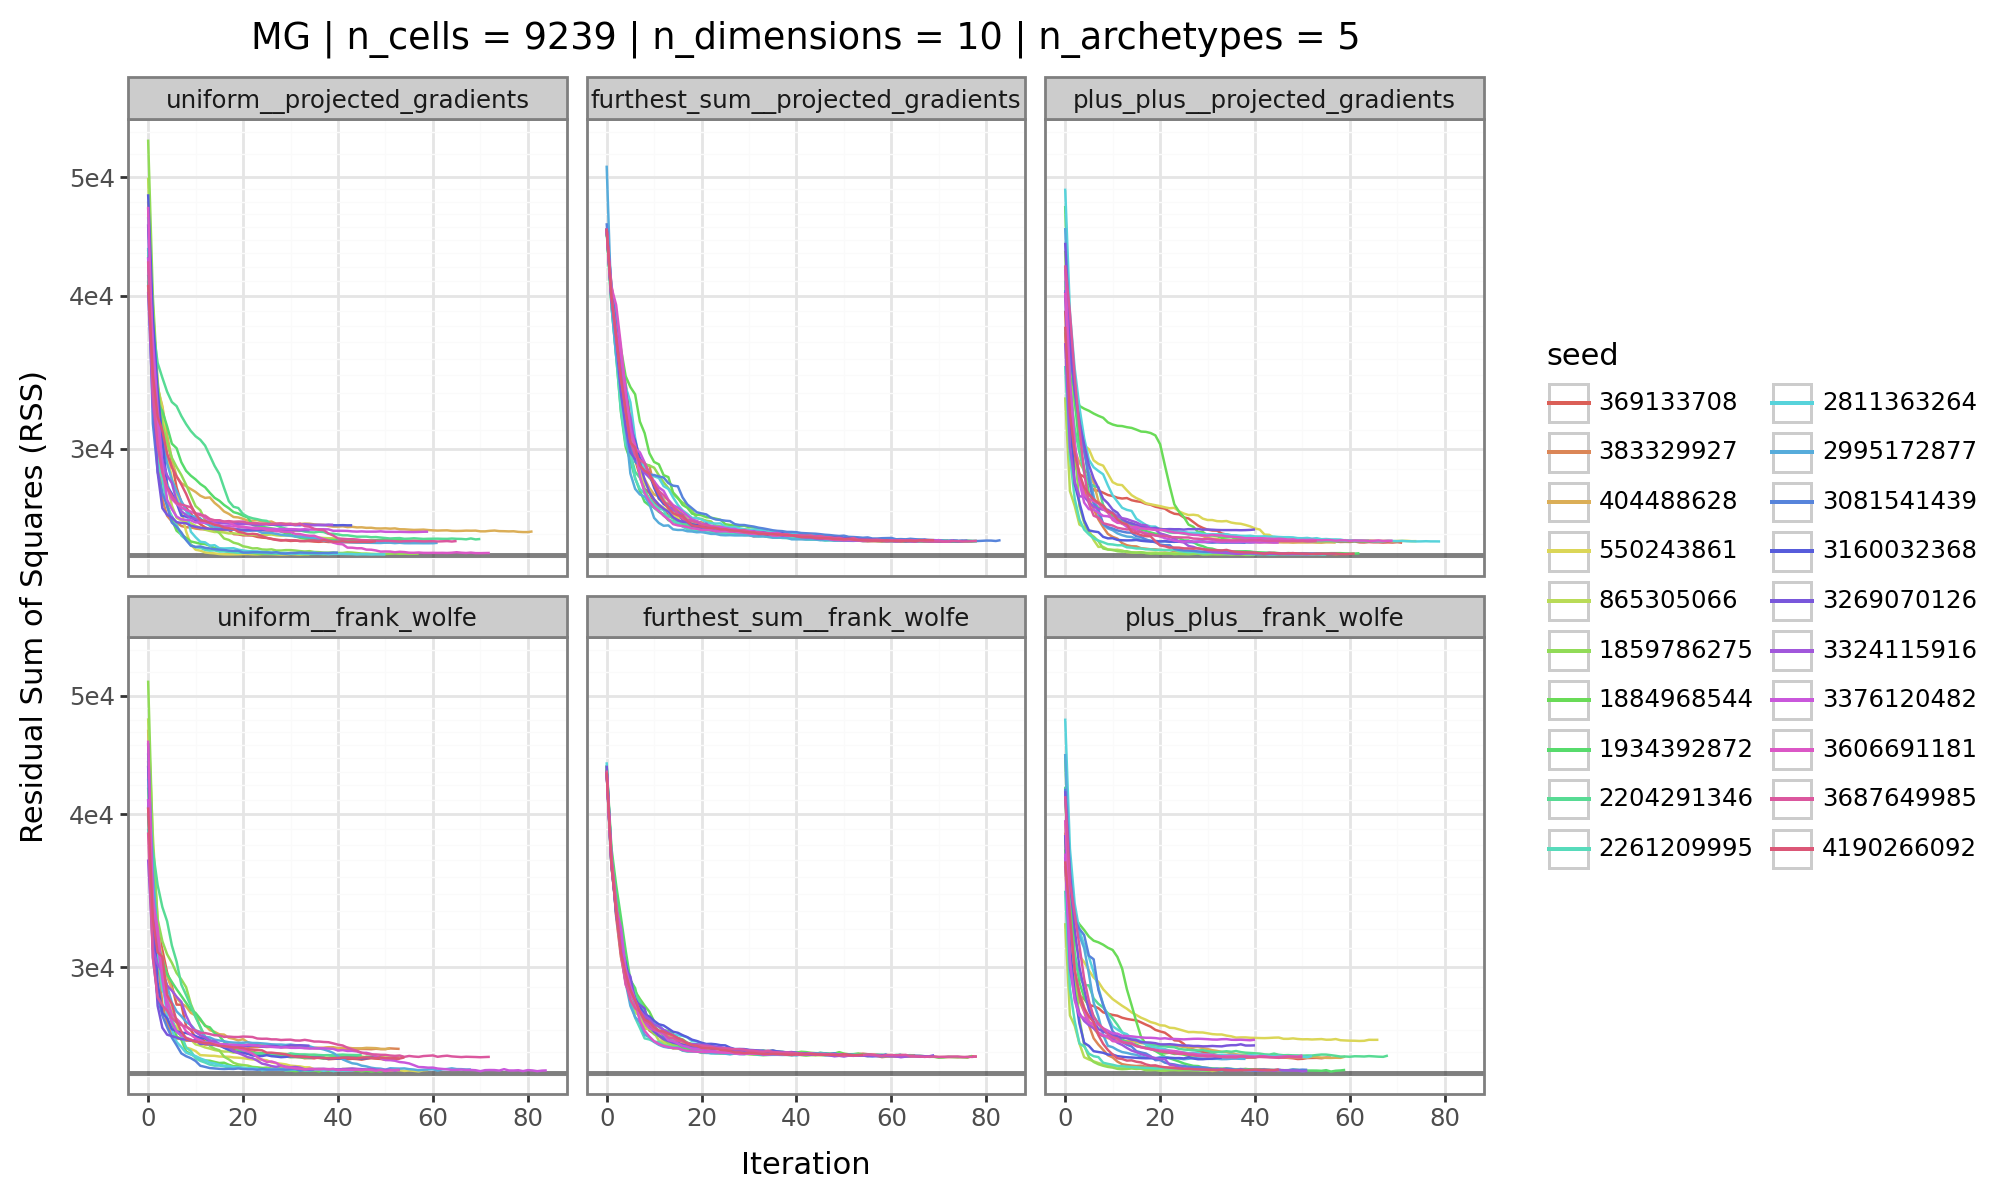

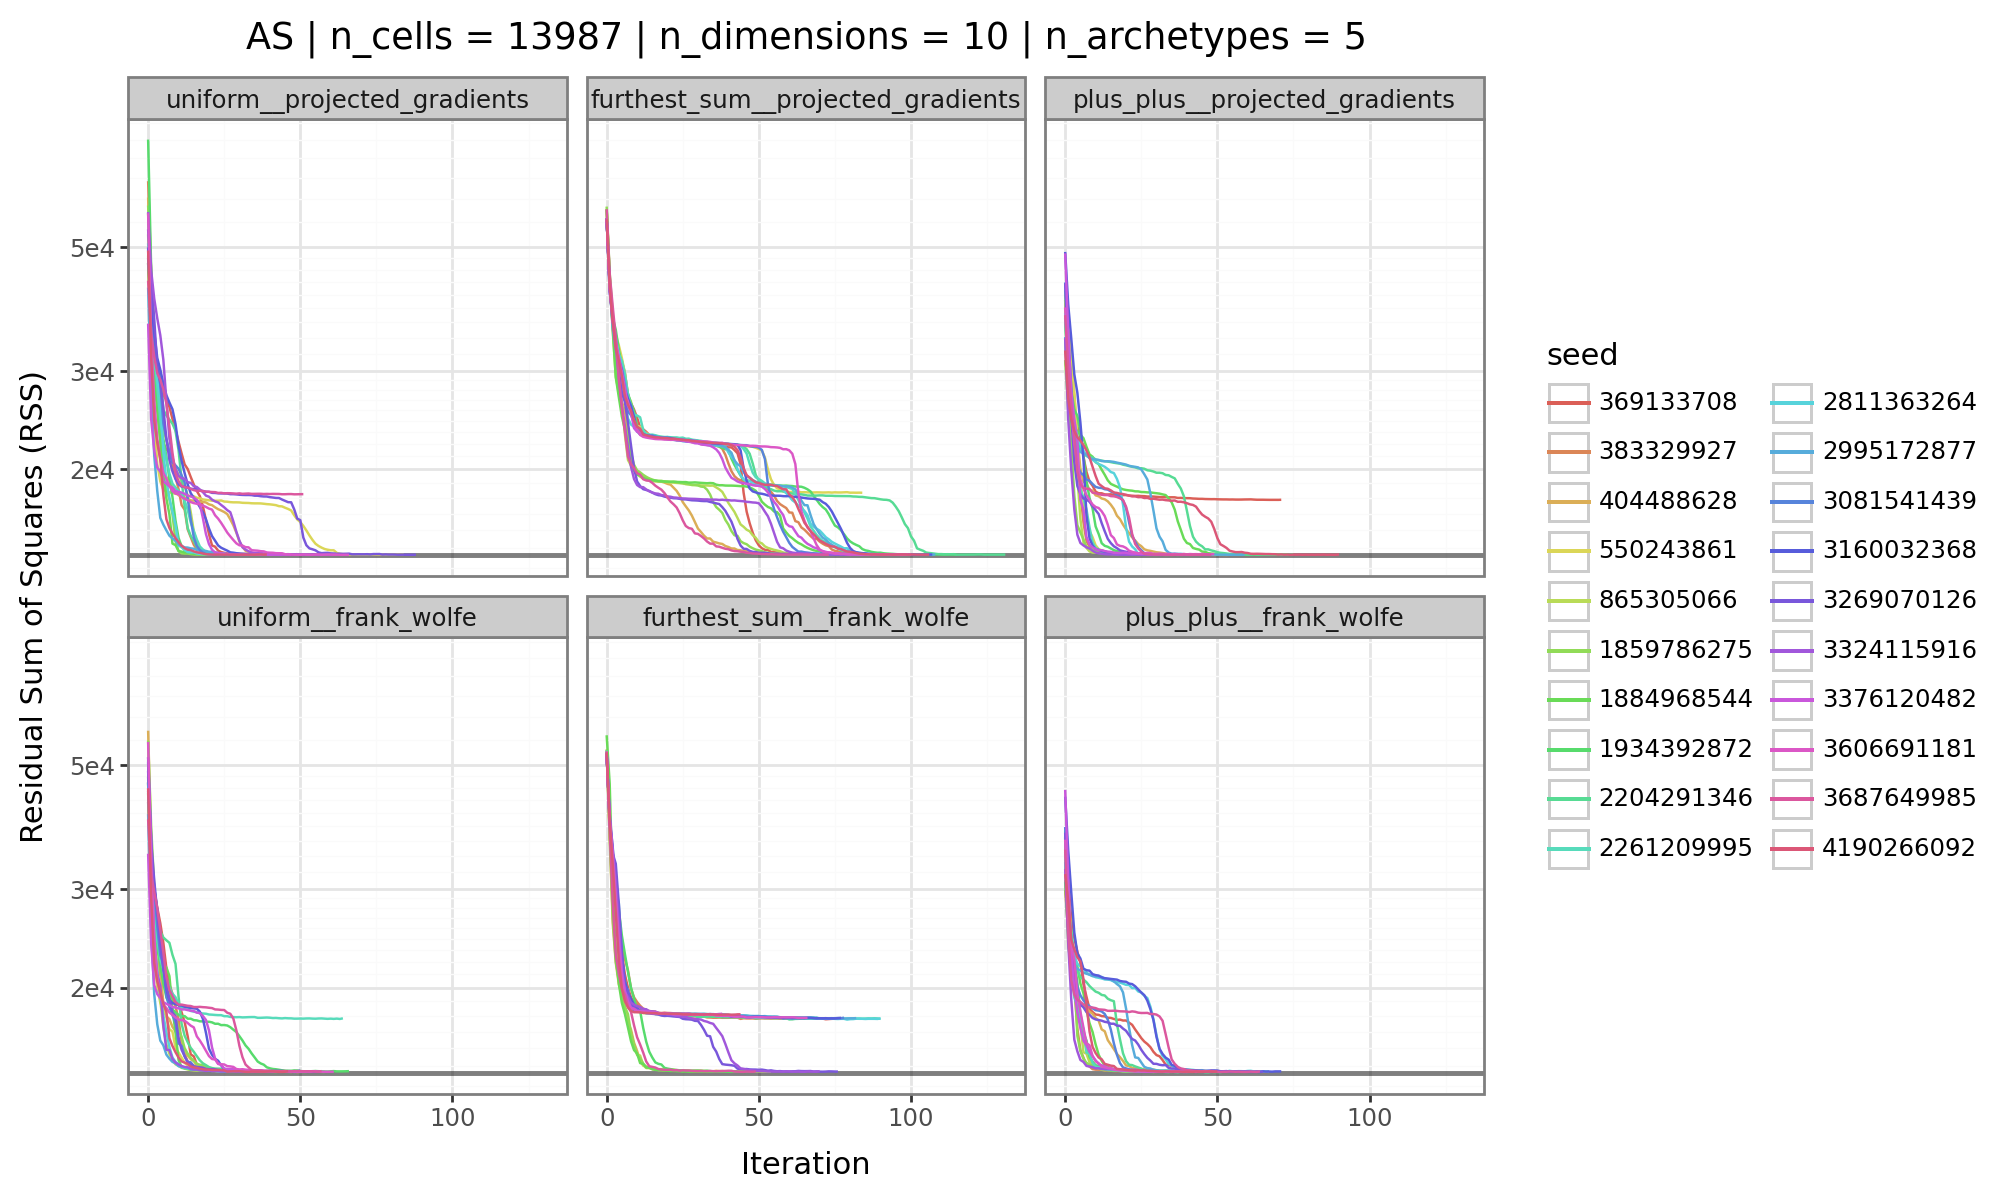

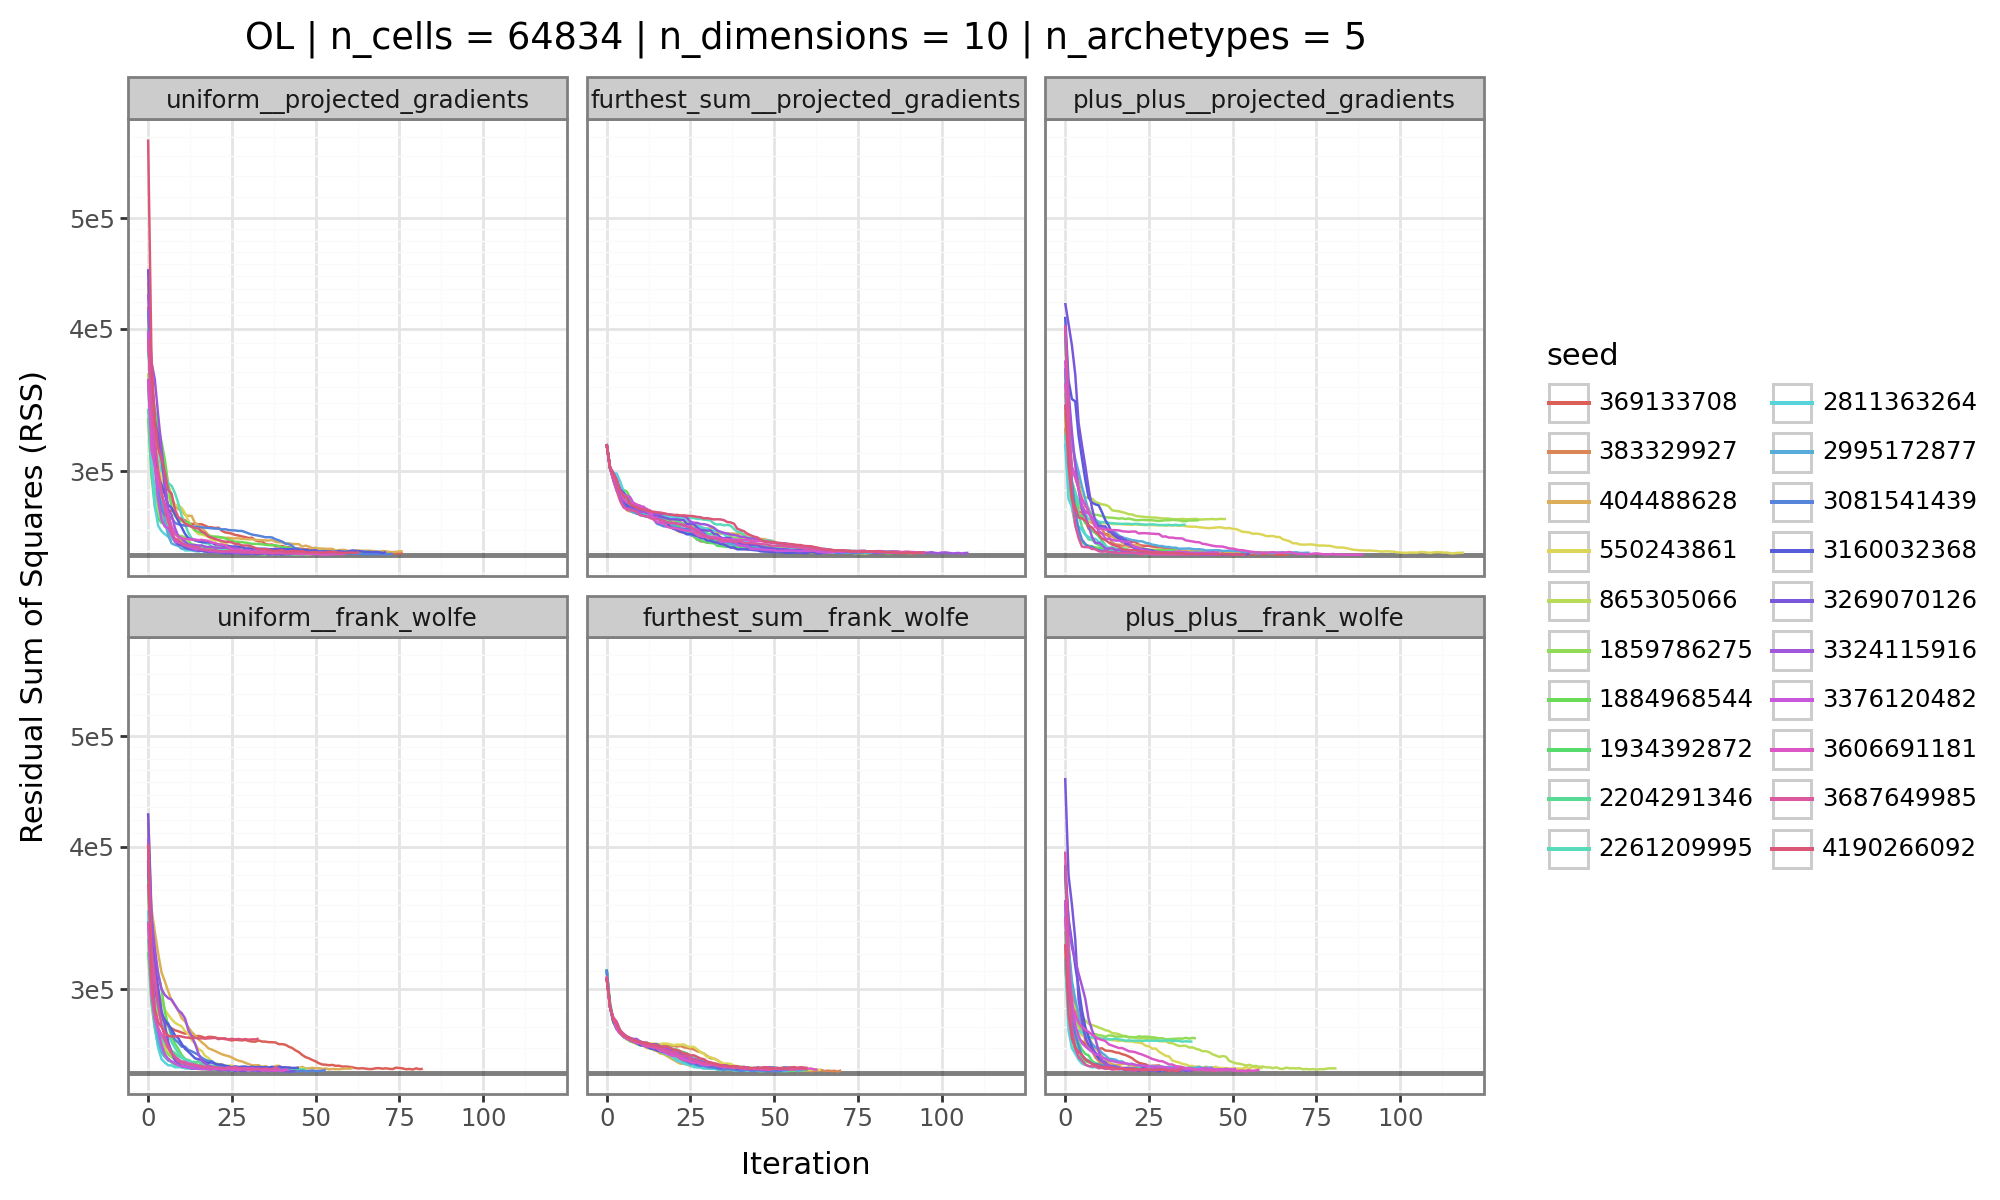

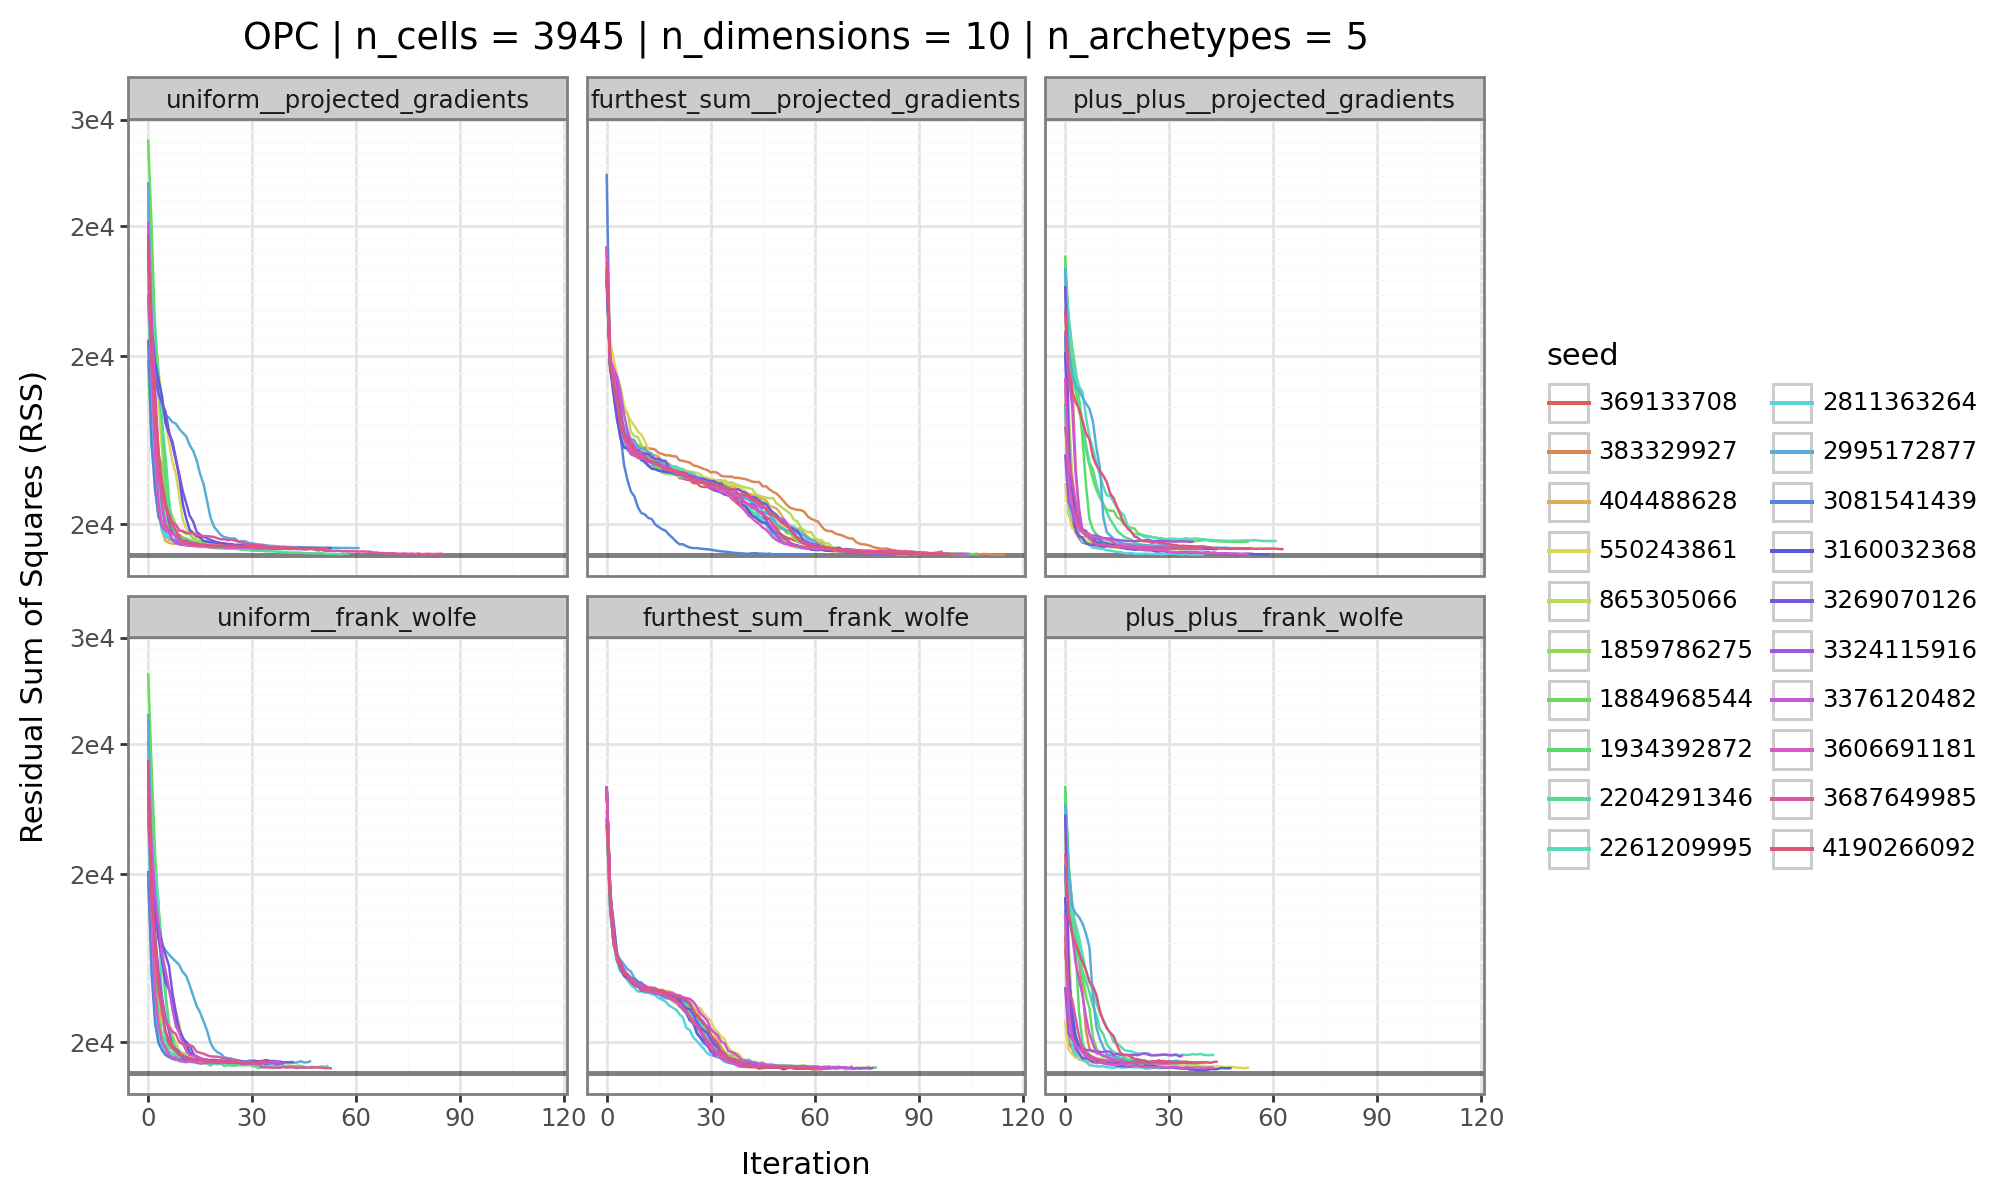

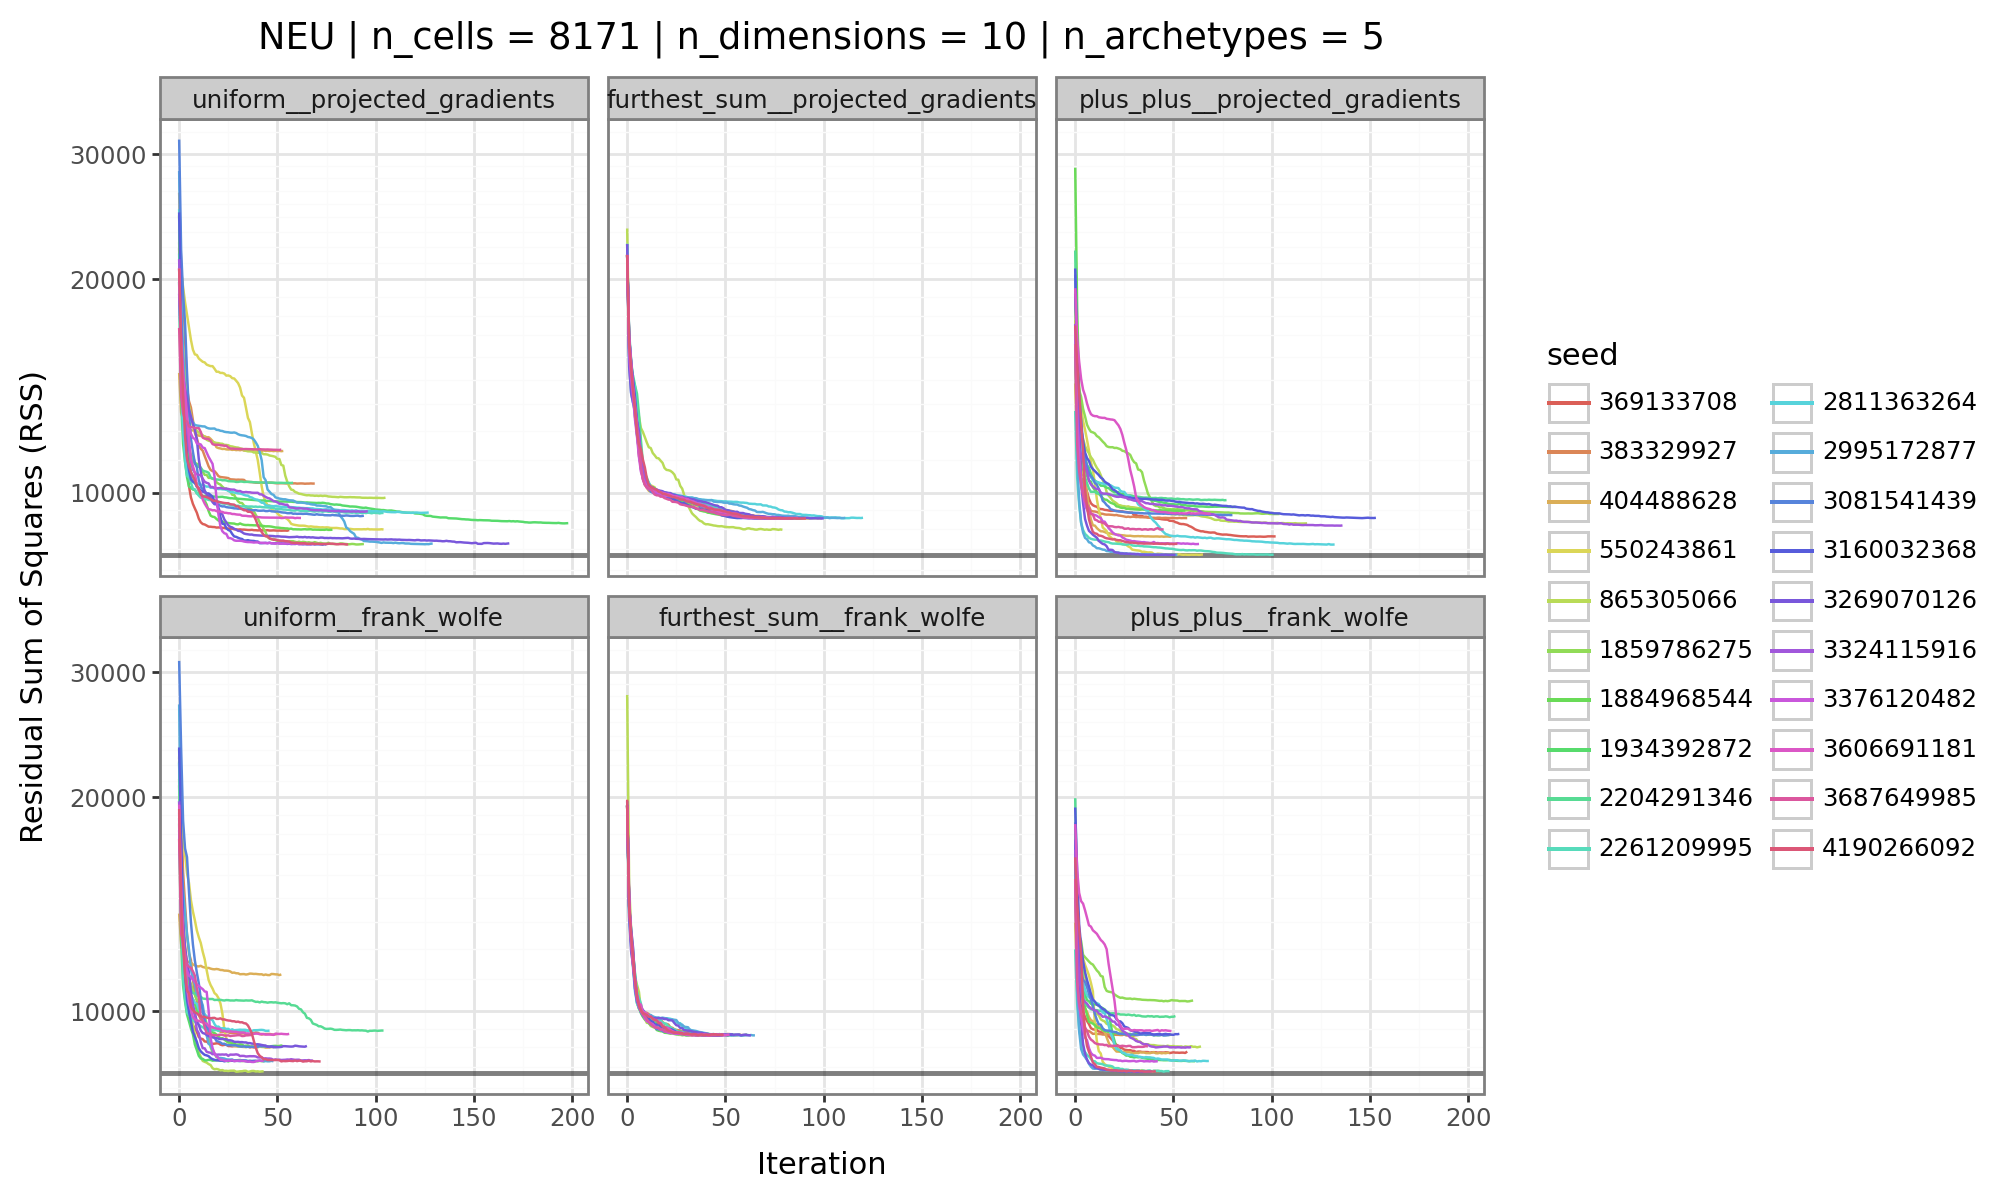

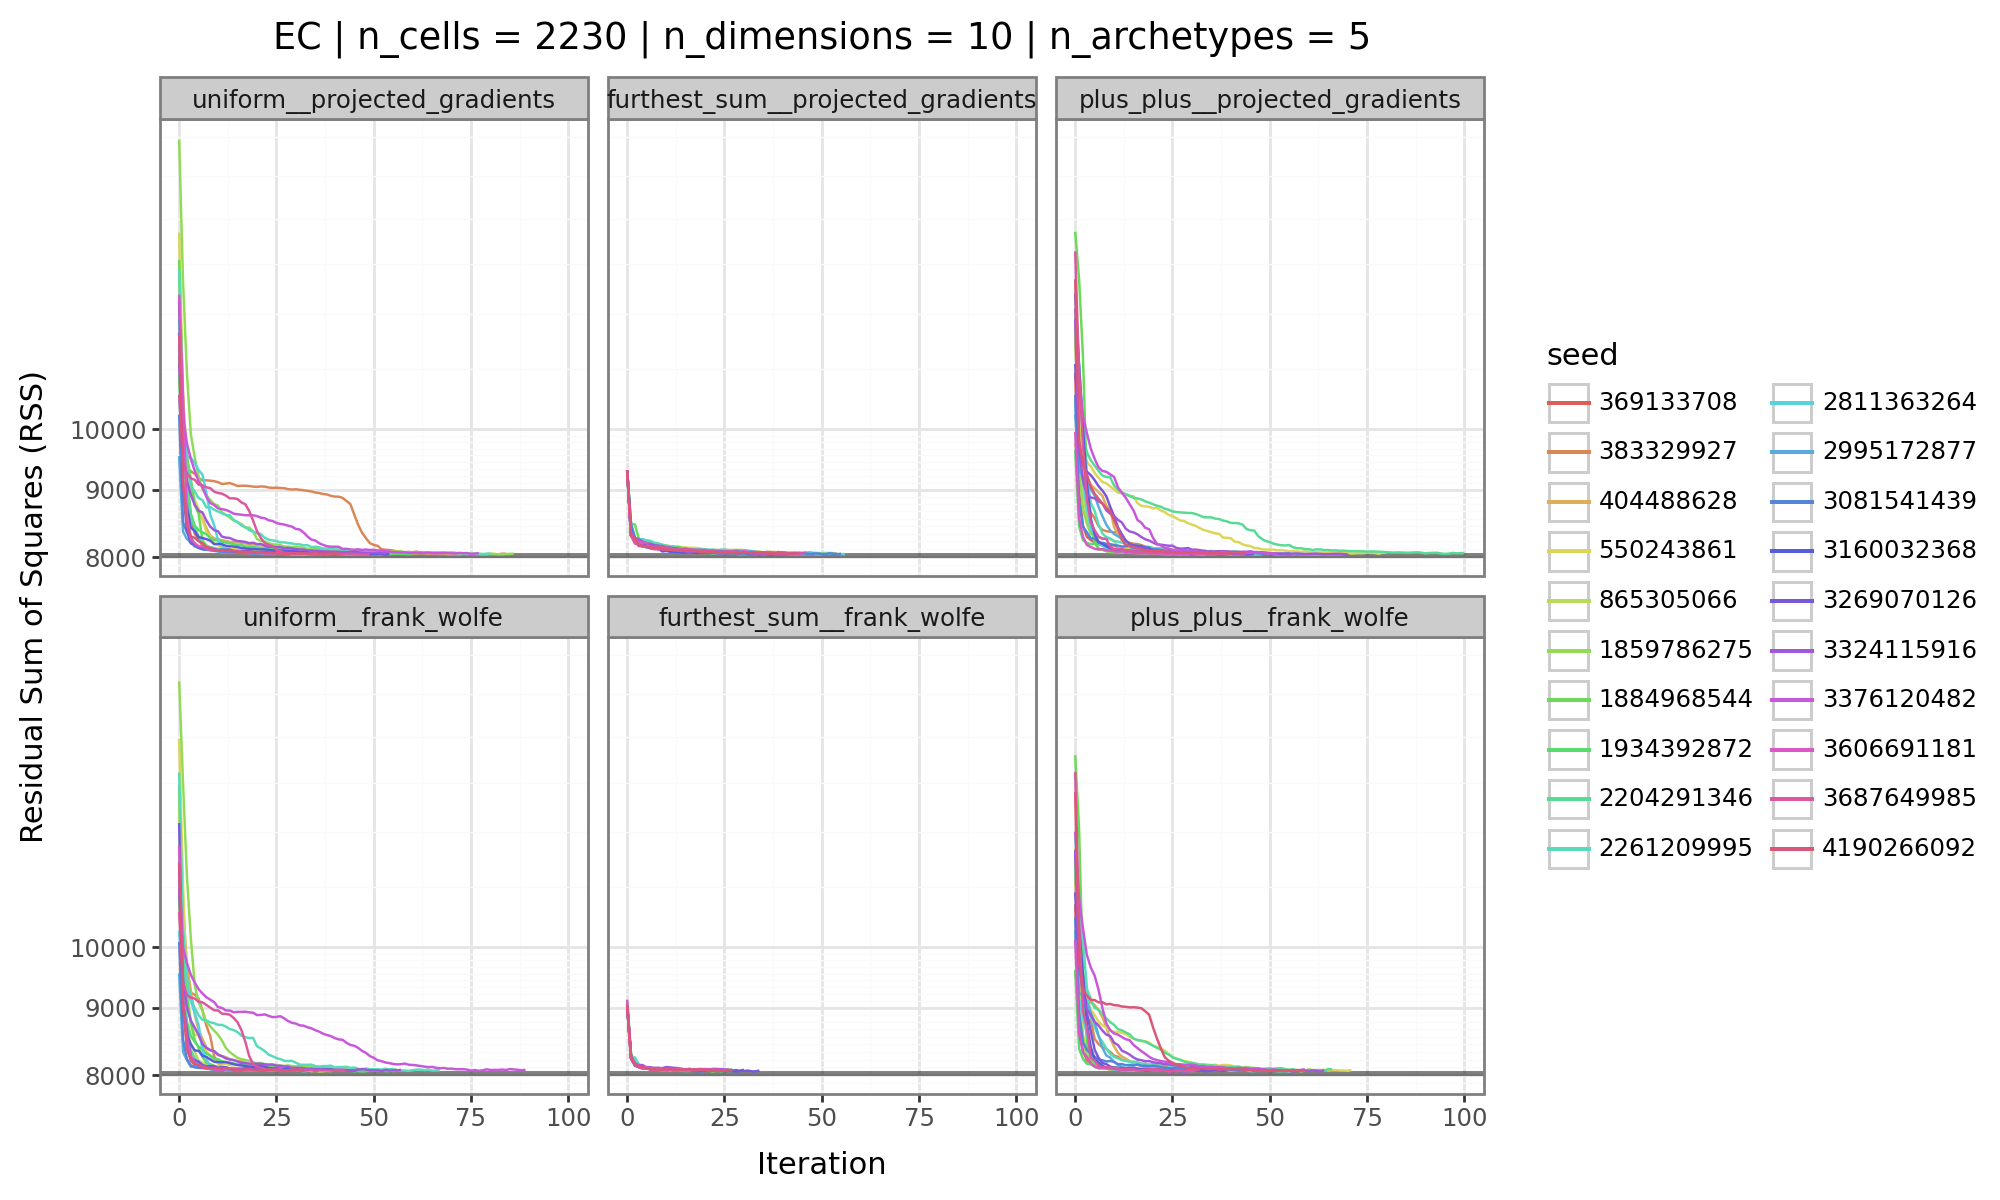

In [85]:
from pathlib import Path
import time
import pickle

from tqdm import tqdm
import pandas as pd
import numpy as np
import scanpy as sc
import partipy as pt
import plotnine as pn
import matplotlib
import matplotlib.pyplot as plt

from data_utils import load_ms_data, load_ms_xenium_data
from const import FIGURE_PATH, OUTPUT_PATH

with open(Path(OUTPUT_PATH) / "ms_bench" / "rss_trace_dict.pkl", "rb") as f:
    rss_trace_dict = pickle.load(f)

result_df = pd.read_csv(Path(OUTPUT_PATH) / "ms_bench" / "results.csv")
result_df["key"] = [init + "__" + optim for init, optim in zip(result_df["init_alg"], result_df["optim_alg"])]

celltype_list = list(rss_trace_dict.keys())

for celltype in celltype_list:

    celltype_result_list = []

    rss_trace_dict_celltype = rss_trace_dict[celltype]

    result_df_subset = result_df.loc[result_df["celltype"]==celltype, :]
    n_samples = result_df_subset["n_samples"].to_numpy()[0]
    n_dimensions = result_df_subset["n_dimensions"].to_numpy()[0]
    #n_archetypes = result_df_subset["n_archetypes"].to_numpy()[0]
    n_archetypes = 5
    figure_title = f"{celltype} | n_cells = {n_samples} | n_dimensions = {n_dimensions} | n_archetypes = {n_archetypes}"
    
    for optim_str, rss_per_seed_dict in rss_trace_dict_celltype.items():


        for seed, trace in rss_per_seed_dict.items():
            tmp_df = pd.DataFrame({"optim": optim_str, "seed": seed, "iter": np.arange(len(trace)), "rss_trace": trace})
            celltype_result_list.append(tmp_df)

    df = pd.concat(celltype_result_list)
    df["seed"] = pd.Categorical(df["seed"])

    df["optim"] = pd.Categorical(df["optim"], 
                                categories=[b + "__" + a for a in pt.const.OPTIM_ALGS for b in pt.const.INIT_ALGS])
    
    p = (pn.ggplot(df)
        + pn.geom_hline(yintercept=min(df["rss_trace"]), color="black", alpha=0.5, size=1)
        + pn.geom_line(pn.aes(x="iter", y="rss_trace", color="seed"), alpha=1.0, size=0.5)
        + pn.scale_y_log10()
        + pn.facet_wrap("optim")
        + pn.theme_bw()
        + pn.theme(figure_size=(10, 6))
        + pn.labs(x="Iteration", y="Residual Sum of Squares (RSS)", color="seed", title=figure_title)
        )
    p.show()


In [70]:
result_df_subset = result_df.loc[(result_df["key"]==optim_str) & (result_df["celltype"]==celltype), :]
result_df_subset

,celltype,time,rss,varexpl,seed,n_samples,n_dimensions,init_alg,optim_alg,key
700,EC,0.291872,8067.2690,0.638239,383329927,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
701,EC,0.336834,8071.4937,0.638050,3324115916,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
702,EC,0.187941,8075.1914,0.637884,2811363264,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
703,EC,0.210595,8067.4775,0.638230,1884968544,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
704,EC,0.177434,8080.9280,0.637627,1859786275,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
705,EC,0.177046,8088.2915,0.637296,3687649985,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
706,EC,0.188024,8069.2866,0.638149,369133708,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
707,EC,0.227532,8074.7510,0.637904,2995172877,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
708,EC,0.173850,8096.6660,0.636921,865305066,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe
709,EC,0.270959,8078.3125,0.637744,404488628,2230,10,plus_plus,frank_wolfe,plus_plus__frank_wolfe


In [72]:
result_df_subset["n_dimensions"]

700    10
701    10
702    10
703    10
704    10
705    10
706    10
707    10
708    10
709    10
710    10
711    10
712    10
713    10
714    10
715    10
716    10
717    10
718    10
719    10
Name: n_dimensions, dtype: int64

In [78]:
result_df_subset["n_samples"].to_numpy()[0]

np.int64(2230)

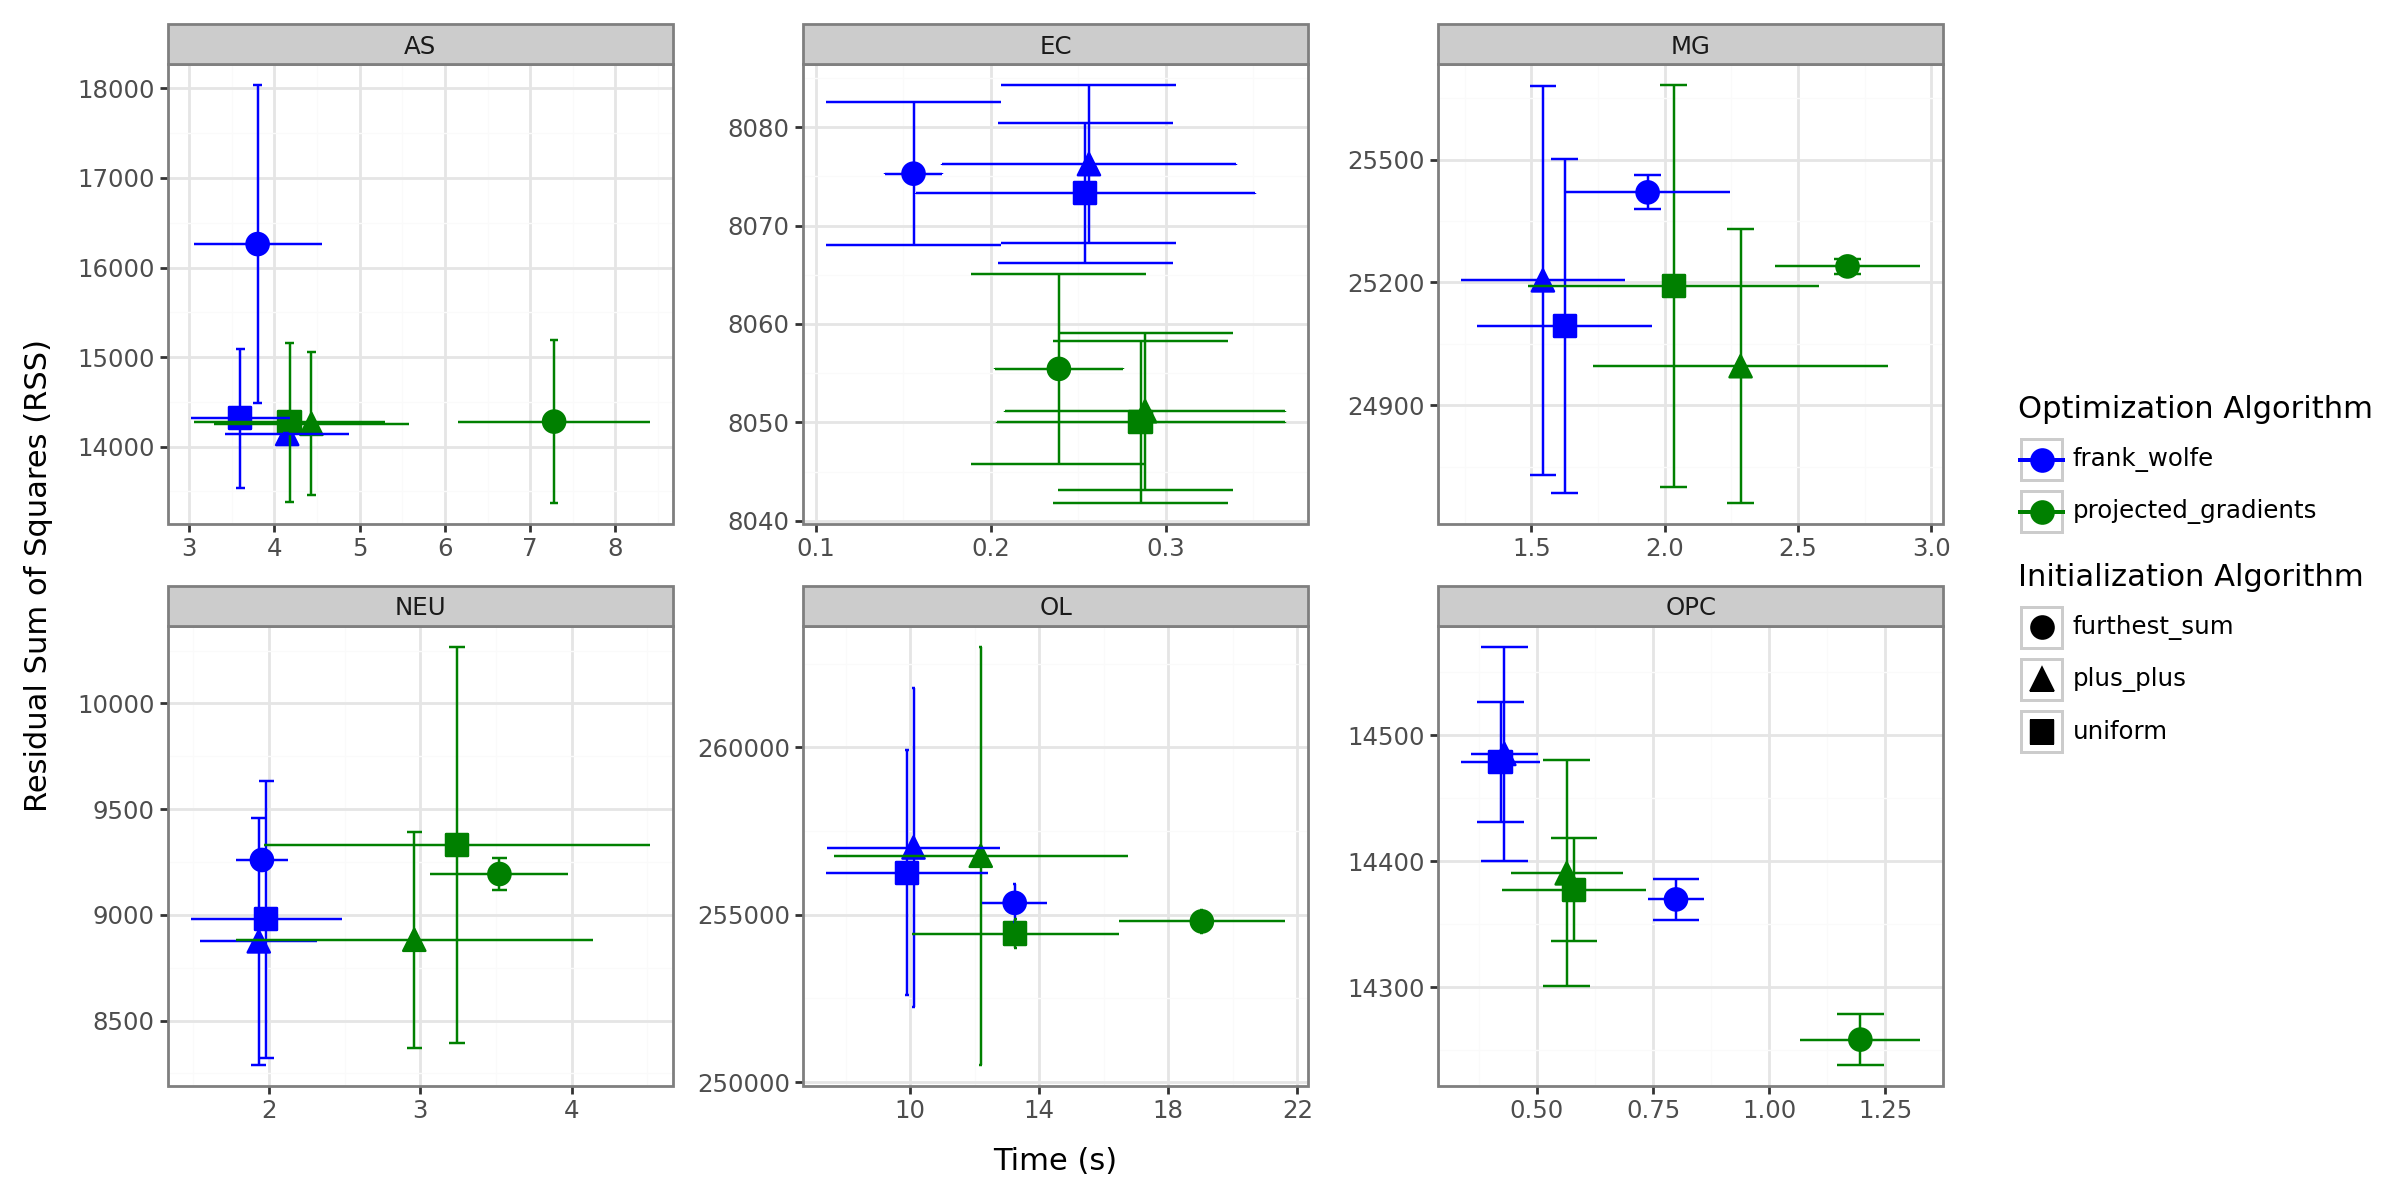

In [84]:
result_df["key"] = [init + "__" + optim for init, optim in zip(result_df["init_alg"], result_df["optim_alg"])]
settings = ["celltype", "init_alg", "optim_alg"]
features = ["time", "rss", "varexpl"]
agg_df = result_df.groupby(settings).agg({f: ["mean", "std"] for f in features})
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df = agg_df.reset_index()

p_rss = (
    pn.ggplot(agg_df)
    + pn.geom_point(pn.aes(x="time_mean", y="rss_mean", color="optim_alg", shape="init_alg"), size=4)
    + pn.geom_errorbar(
        pn.aes(x="time_mean", ymin="rss_mean - rss_std", ymax="rss_mean + rss_std", color="optim_alg"),
        width=0.1)
    + pn.geom_errorbarh(
        pn.aes(y="rss_mean", xmin="time_mean - time_std", xmax="time_mean + time_std", color="optim_alg"),
        height=0.1)
    + pn.facet_wrap(facets="celltype", ncol=3, scales="free")
    + pn.labs(x="Time (s)", y="Residual Sum of Squares (RSS)", 
              color="Optimization Algorithm", shape="Initialization Algorithm") 
    + pn.theme_bw() 
    + pn.theme(figure_size=(12, 6)) 
    + pn.scale_color_manual(values={"projected_gradients": "green", "frank_wolfe": "blue"})
)
p_rss